# Volatility Events Analysis

This notebook focuses on analyzing volatility events for Squid_Ink, such as high PCO (Price Change Oscillator) values and oscillating variance spikes. We'll use only the first 20,000 timestamps (in-sample data) for our analysis.

In [1]:
import sys
import os

# Import our backtester package
sys.path.append(os.path.abspath('../../'))
from backtester import get_price_data, get_vwap, relative_entropy_binned
print("Using backtester package")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

Using backtester package


## 1. Load Data

First, let's load the Squid_Ink price data and limit it to the first 20,000 timestamps (in-sample data).

In [2]:
# Load data directly using backtester package
print("Loading price data...")
prices = get_price_data('SQUID_INK', 1)
print(f"Loaded {len(prices)} price data points")

# Limit to first 20,000 timestamps (in-sample data)
in_sample_prices = prices.iloc[:20000]
print(f"Limited to {len(in_sample_prices)} in-sample data points")

# Get VWAP
print("Getting VWAP for SQUID_INK...")
squid_vwap = in_sample_prices['vwap']
print(f"Got VWAP with {len(squid_vwap)} data points")
print(f"VWAP range: {squid_vwap.min()} to {squid_vwap.max()}")

# Calculate log returns
log_ret = np.log(squid_vwap).diff().dropna()
print(f"Calculated log returns with {len(log_ret)} data points")

Loading price data...
Loading real data for SQUID_INK from round 1...
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-2.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_-1.csv
Found data file at ../../../Prosperity 3 Data/Round 1/prices_round_1_day_0.csv
Successfully loaded real data with 30000 rows
Loaded 30000 price data points
Limited to 20000 in-sample data points
Getting VWAP for SQUID_INK...
Got VWAP with 20000 data points
VWAP range: 1832.0 to 2187.3880597014927
Calculated log returns with 19999 data points


## 2. Calculate Volatility Metrics

Let's calculate various volatility metrics including PCO (Price Change Oscillator) and oscillating variance.

In [3]:
# Calculate rolling volatility (standard deviation of returns)
short_window = 20
long_window = 100

# Short-term volatility
short_vol = log_ret.rolling(window=short_window).std()

# Long-term volatility
long_vol = log_ret.rolling(window=long_window).std()

# Calculate PCO (Price Change Oscillator)
# PCO measures the ratio of short-term to long-term volatility
pco = short_vol / long_vol

# Calculate oscillating variance
# This measures the variance of the volatility itself
osc_var = short_vol.rolling(window=short_window).var()

# Create a DataFrame with all volatility metrics
vol_metrics = pd.DataFrame({
    'log_ret': log_ret,
    'short_vol': short_vol,
    'long_vol': long_vol,
    'pco': pco,
    'osc_var': osc_var
})

# Display the first few rows
vol_metrics.head(10)

,log_ret,short_vol,long_vol,pco,osc_var
timestamp,,,,,
100,-0.000363,NaN,NaN,NaN,NaN
200,-0.000145,NaN,NaN,NaN,NaN
300,-0.000242,NaN,NaN,NaN,NaN
400,-0.000250,NaN,NaN,NaN,NaN
500,0.000254,NaN,NaN,NaN,NaN
600,0.000246,NaN,NaN,NaN,NaN
700,0.000750,NaN,NaN,NaN,NaN
800,0.000261,NaN,NaN,NaN,NaN
900,-0.000769,NaN,NaN,NaN,NaN


## 3. Visualize Volatility Metrics

Let's visualize the volatility metrics over time and their distributions.

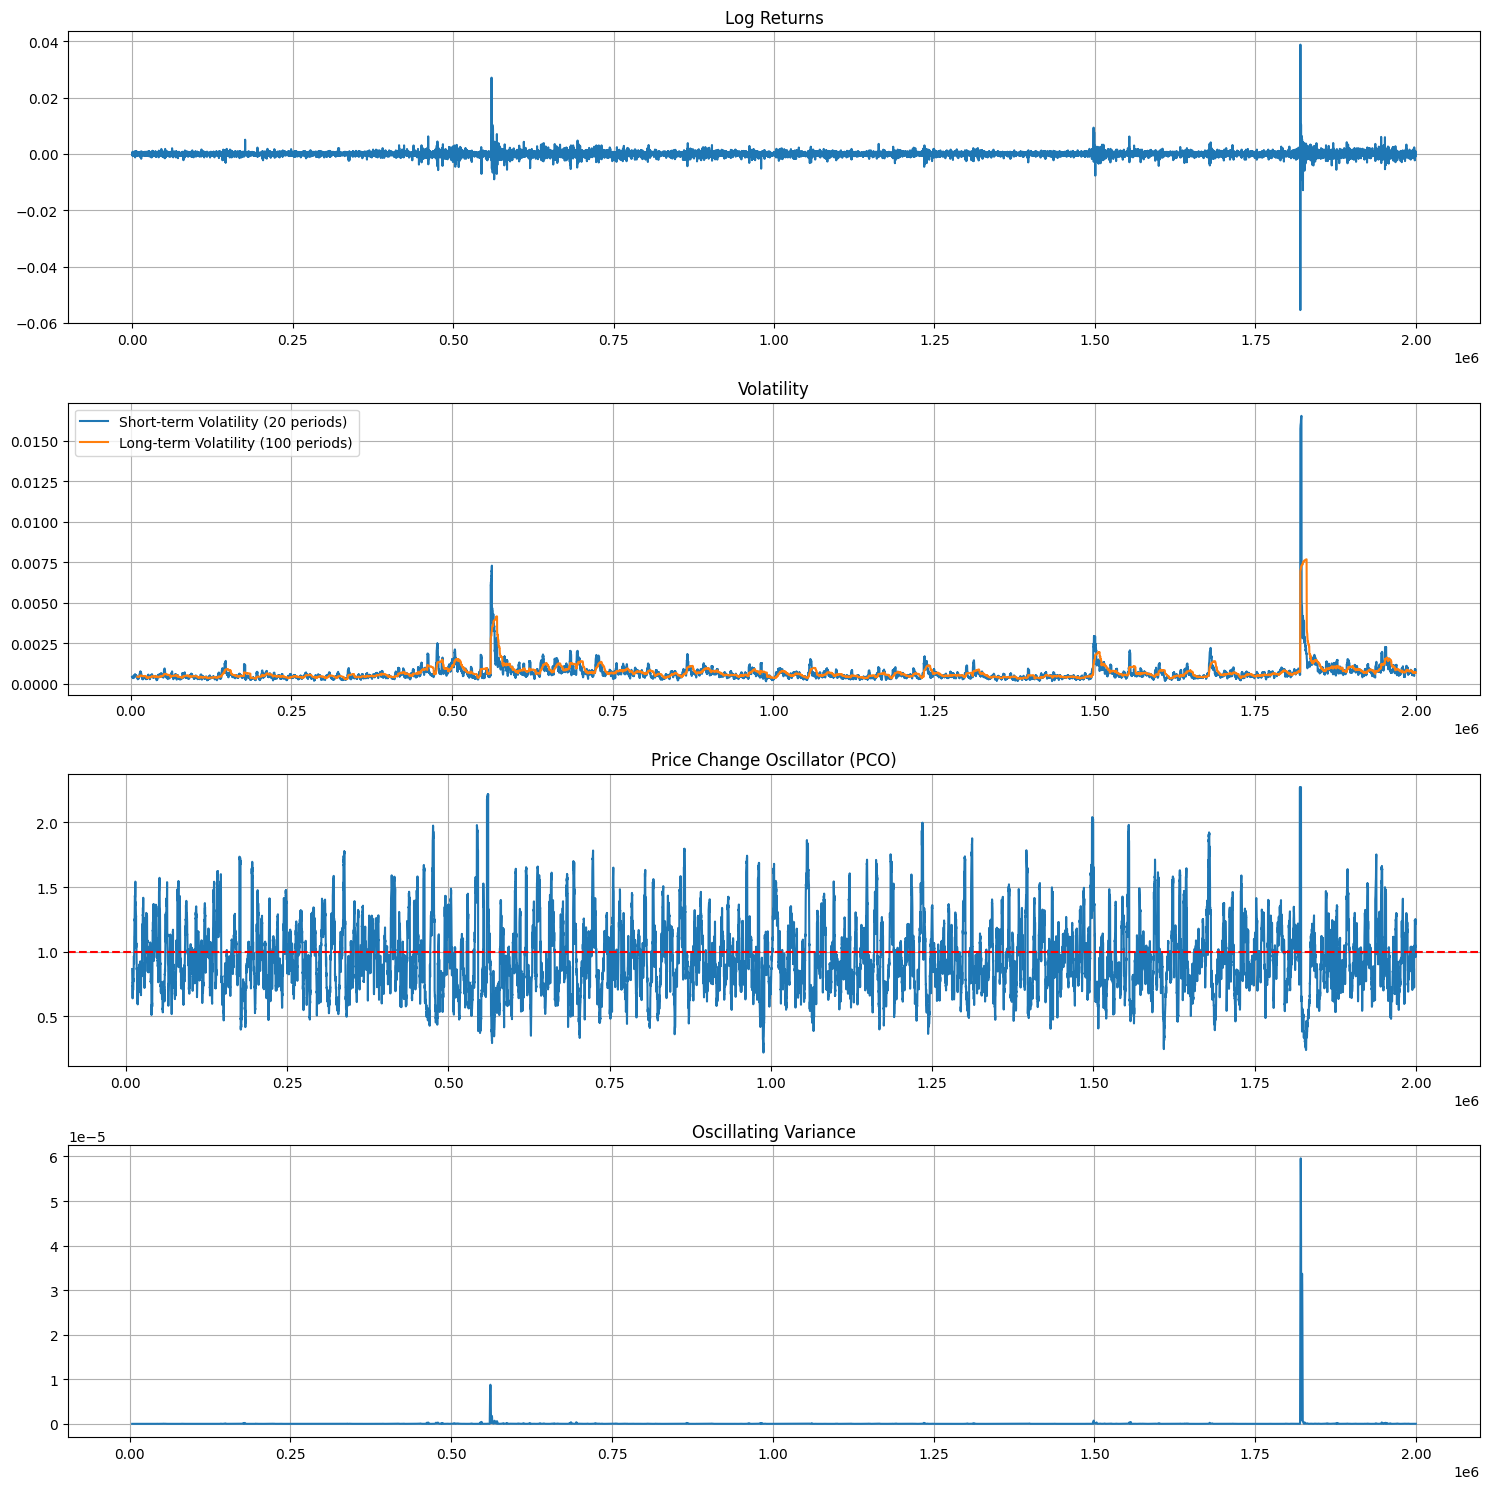

In [4]:
# Plot volatility metrics over time
plt.figure(figsize=(15, 15))

# Plot log returns
plt.subplot(4, 1, 1)
plt.plot(log_ret)
plt.title('Log Returns')
plt.grid(True)

# Plot short-term and long-term volatility
plt.subplot(4, 1, 2)
plt.plot(short_vol, label=f'Short-term Volatility ({short_window} periods)')
plt.plot(long_vol, label=f'Long-term Volatility ({long_window} periods)')
plt.title('Volatility')
plt.legend()
plt.grid(True)

# Plot PCO
plt.subplot(4, 1, 3)
plt.plot(pco)
plt.axhline(y=1.0, color='r', linestyle='--')  # Reference line at PCO = 1.0
plt.title('Price Change Oscillator (PCO)')
plt.grid(True)

# Plot oscillating variance
plt.subplot(4, 1, 4)
plt.plot(osc_var)
plt.title('Oscillating Variance')
plt.grid(True)

plt.tight_layout()
plt.show()

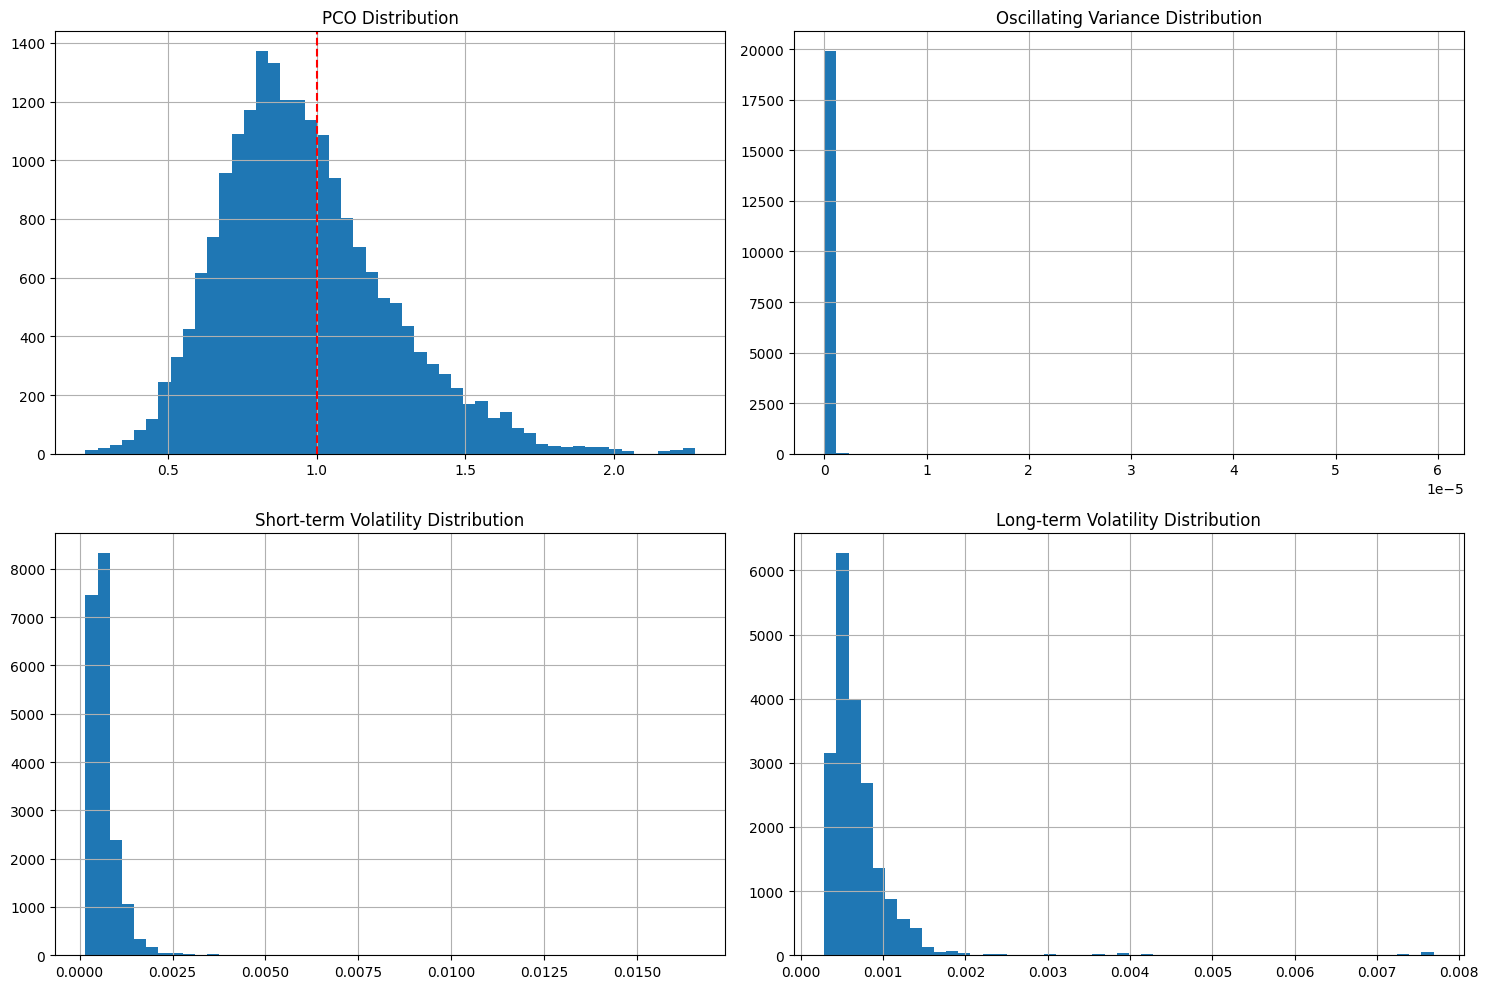

In [5]:
# Plot distributions of volatility metrics
plt.figure(figsize=(15, 10))

# Plot PCO distribution
plt.subplot(2, 2, 1)
plt.hist(pco.dropna(), bins=50)
plt.axvline(x=1.0, color='r', linestyle='--')  # Reference line at PCO = 1.0
plt.title('PCO Distribution')
plt.grid(True)

# Plot oscillating variance distribution
plt.subplot(2, 2, 2)
plt.hist(osc_var.dropna(), bins=50)
plt.title('Oscillating Variance Distribution')
plt.grid(True)

# Plot short-term volatility distribution
plt.subplot(2, 2, 3)
plt.hist(short_vol.dropna(), bins=50)
plt.title('Short-term Volatility Distribution')
plt.grid(True)

# Plot long-term volatility distribution
plt.subplot(2, 2, 4)
plt.hist(long_vol.dropna(), bins=50)
plt.title('Long-term Volatility Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

## 4. Define Volatility Events

Let's define volatility events based on extreme values of PCO and oscillating variance.

In [6]:
# Calculate statistics for PCO
pco_mean = pco.mean()
pco_std = pco.std()

print(f"PCO mean: {pco_mean:.4f}")
print(f"PCO std: {pco_std:.4f}")

# Calculate statistics for oscillating variance
osc_var_mean = osc_var.mean()
osc_var_std = osc_var.std()

print(f"Oscillating variance mean: {osc_var_mean:.8f}")
print(f"Oscillating variance std: {osc_var_std:.8f}")

# Define thresholds for PCO events
pco_thresholds = {
    'moderate': pco_mean + 1.5 * pco_std,  # 1.5 standard deviations
    'high': pco_mean + 2.0 * pco_std,      # 2.0 standard deviations
    'extreme': pco_mean + 2.5 * pco_std    # 2.5 standard deviations
}

# Define thresholds for oscillating variance events
osc_var_thresholds = {
    'moderate': osc_var_mean + 1.5 * osc_var_std,  # 1.5 standard deviations
    'high': osc_var_mean + 2.0 * osc_var_std,      # 2.0 standard deviations
    'extreme': osc_var_mean + 2.5 * osc_var_std    # 2.5 standard deviations
}

# Display the thresholds
print("\nPCO Thresholds:")
for name, threshold in pco_thresholds.items():
    print(f"{name.capitalize()} PCO threshold: {threshold:.4f}")

print("\nOscillating Variance Thresholds:")
for name, threshold in osc_var_thresholds.items():
    print(f"{name.capitalize()} oscillating variance threshold: {threshold:.8f}")

PCO mean: 0.9615
PCO std: 0.2855
Oscillating variance mean: 0.00000009
Oscillating variance std: 0.00000159

PCO Thresholds:
Moderate PCO threshold: 1.3897
High PCO threshold: 1.5325
Extreme PCO threshold: 1.6753

Oscillating Variance Thresholds:
Moderate oscillating variance threshold: 0.00000246
High oscillating variance threshold: 0.00000326
Extreme oscillating variance threshold: 0.00000405


In [7]:
# Identify volatility events
vol_events = pd.DataFrame(index=vol_metrics.index)
vol_events['pco'] = pco
vol_events['osc_var'] = osc_var

# Classify PCO events by magnitude
for name, threshold in pco_thresholds.items():
    vol_events[f'{name}_pco'] = (vol_events['pco'] > threshold).astype(int)

# Classify oscillating variance events by magnitude
for name, threshold in osc_var_thresholds.items():
    vol_events[f'{name}_osc_var'] = (vol_events['osc_var'] > threshold).astype(int)

# Display the first few rows
vol_events.head(10)

,pco,osc_var,moderate_pco,high_pco,extreme_pco,moderate_osc_var,high_osc_var,extreme_osc_var
timestamp,,,,,,,,
100,NaN,NaN,0,0,0,0,0,0
200,NaN,NaN,0,0,0,0,0,0
300,NaN,NaN,0,0,0,0,0,0
400,NaN,NaN,0,0,0,0,0,0
500,NaN,NaN,0,0,0,0,0,0
600,NaN,NaN,0,0,0,0,0,0
700,NaN,NaN,0,0,0,0,0,0
800,NaN,NaN,0,0,0,0,0,0
900,NaN,NaN,0,0,0,0,0,0


## 5. Analyze Volatility Events

Let's analyze the frequency and characteristics of volatility events.

In [8]:
# Count the number of volatility events by type
vol_counts = {}

for col in vol_events.columns:
    if col.startswith('moderate_') or col.startswith('high_') or col.startswith('extreme_'):
        vol_counts[col] = vol_events[col].sum()

# Calculate the percentage of volatility events
total_points = len(vol_events.dropna())
vol_percentages = {k: v / total_points * 100 for k, v in vol_counts.items()}

# Display the counts and percentages
counts_df = pd.DataFrame({
    'Count': vol_counts,
    'Percentage (%)': vol_percentages
})

counts_df

,Count,Percentage (%)
moderate_pco,1638,8.231156
high_pco,826,4.150754
extreme_pco,331,1.663317
moderate_osc_var,55,0.276382
high_osc_var,53,0.266332
extreme_osc_var,52,0.261307


## 6. Visualize Volatility Events

Let's visualize the volatility events on the VWAP chart.

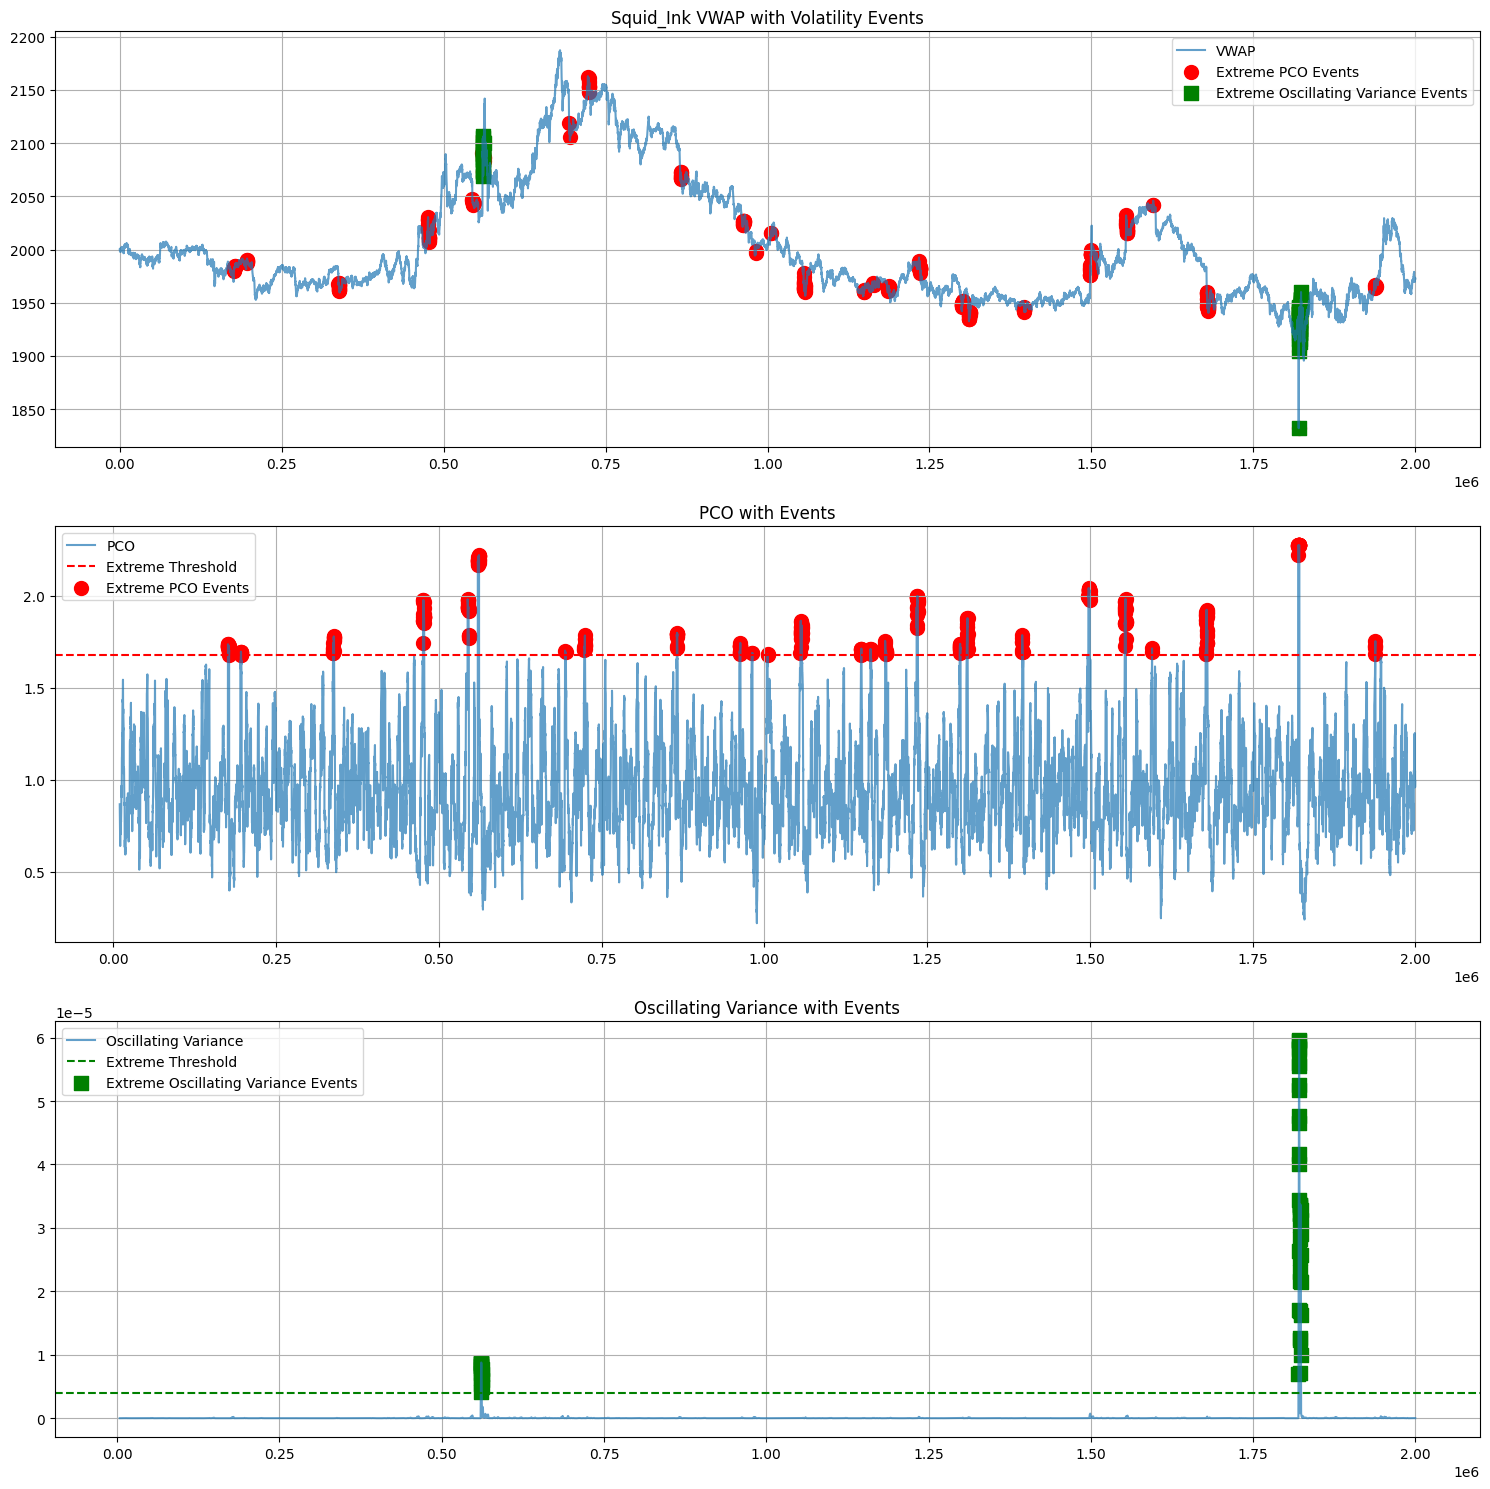

In [9]:
# Plot VWAP with volatility events
plt.figure(figsize=(15, 15))

# Plot VWAP
plt.subplot(3, 1, 1)
plt.plot(squid_vwap, label='VWAP', alpha=0.7)

# Plot extreme PCO events
extreme_pco_events = vol_events[vol_events['extreme_pco'] == 1].index
plt.scatter(extreme_pco_events, squid_vwap.loc[extreme_pco_events], 
            marker='o', s=100, color='red', label='Extreme PCO Events')

# Plot extreme oscillating variance events
extreme_osc_var_events = vol_events[vol_events['extreme_osc_var'] == 1].index
plt.scatter(extreme_osc_var_events, squid_vwap.loc[extreme_osc_var_events], 
            marker='s', s=100, color='green', label='Extreme Oscillating Variance Events')

plt.title('Squid_Ink VWAP with Volatility Events')
plt.legend()
plt.grid(True)

# Plot PCO with events
plt.subplot(3, 1, 2)
plt.plot(pco, label='PCO', alpha=0.7)
plt.axhline(y=pco_thresholds['extreme'], color='r', linestyle='--', label='Extreme Threshold')
plt.scatter(extreme_pco_events, pco.loc[extreme_pco_events], 
            marker='o', s=100, color='red', label='Extreme PCO Events')
plt.title('PCO with Events')
plt.legend()
plt.grid(True)

# Plot oscillating variance with events
plt.subplot(3, 1, 3)
plt.plot(osc_var, label='Oscillating Variance', alpha=0.7)
plt.axhline(y=osc_var_thresholds['extreme'], color='g', linestyle='--', label='Extreme Threshold')
plt.scatter(extreme_osc_var_events, osc_var.loc[extreme_osc_var_events], 
            marker='s', s=100, color='green', label='Extreme Oscillating Variance Events')
plt.title('Oscillating Variance with Events')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 7. Analyze Post-Event Returns

Let's analyze the returns following volatility events.

In [10]:
# Define function to calculate post-event returns
def calculate_post_event_returns(events, returns, event_col, horizons=[1, 5, 10, 20]):
    """Calculate returns after events for different time horizons."""
    post_returns = {}
    
    # Get event timestamps
    event_times = events[events[event_col] == 1].index
    
    if len(event_times) == 0:
        return {h: np.nan for h in horizons}
    
    # Calculate post-event returns for each horizon
    for horizon in horizons:
        horizon_returns = []
        
        for time in event_times:
            try:
                # Get the index position
                idx = returns.index.get_loc(time)
                
                # Calculate cumulative return for the horizon
                if idx + horizon < len(returns):
                    cum_ret = returns.iloc[idx+1:idx+horizon+1].sum()
                    horizon_returns.append(cum_ret)
            except:
                continue
        
        if horizon_returns:
            post_returns[horizon] = np.mean(horizon_returns)
        else:
            post_returns[horizon] = np.nan
    
    return post_returns

In [11]:
# Calculate post-event returns for different volatility events
horizons = [1, 5, 10, 20, 50]
post_returns = {}

for col in vol_events.columns:
    if col.startswith('moderate_') or col.startswith('high_') or col.startswith('extreme_'):
        post_returns[col] = calculate_post_event_returns(vol_events, log_ret, col, horizons)

# Convert to DataFrame for easier analysis
post_returns_df = pd.DataFrame(post_returns)

# Display the results
post_returns_df

,moderate_pco,high_pco,extreme_pco,moderate_osc_var,high_osc_var,extreme_osc_var
1,0.000009,0.000037,0.000059,0.001056,0.001146,0.001201
5,0.000002,0.000043,0.000035,0.001561,0.001740,0.001608
10,0.000068,0.000262,0.000284,0.003018,0.003447,0.003162
20,0.000248,0.000749,0.001137,0.007928,0.008353,0.008090
50,0.000628,0.001374,0.000894,-0.004913,-0.004702,-0.004732


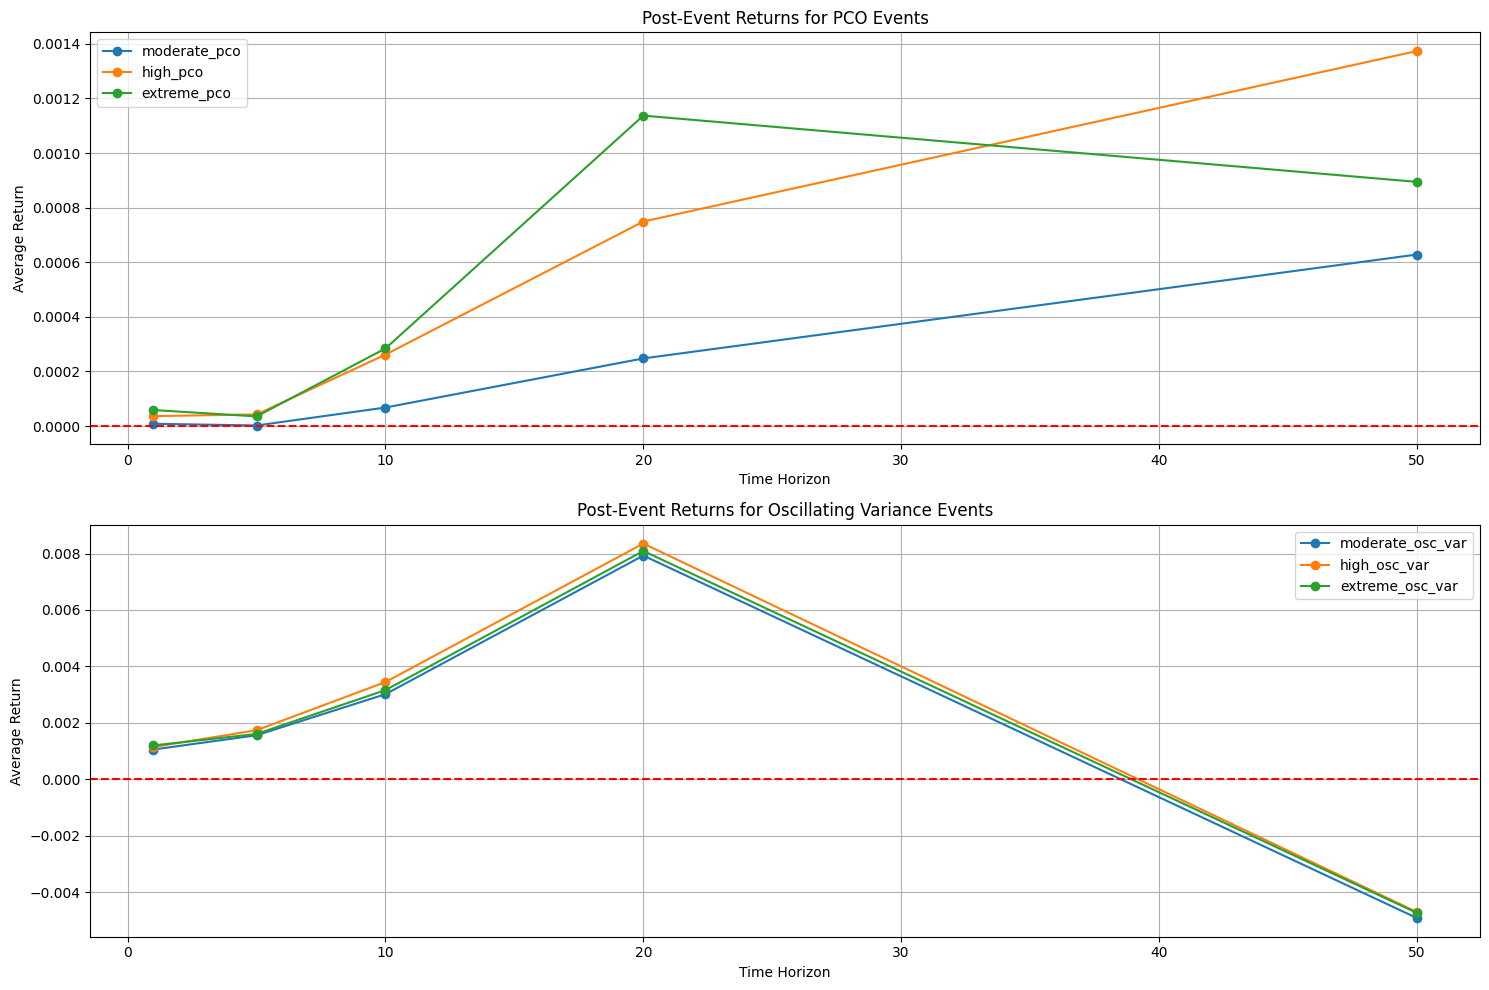

In [12]:
# Visualize post-event returns
plt.figure(figsize=(15, 10))

# Plot post-event returns for PCO events
plt.subplot(2, 1, 1)
for col in [c for c in post_returns_df.columns if 'pco' in c]:
    plt.plot(post_returns_df.index, post_returns_df[col], marker='o', label=col)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Post-Event Returns for PCO Events')
plt.xlabel('Time Horizon')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)

# Plot post-event returns for oscillating variance events
plt.subplot(2, 1, 2)
for col in [c for c in post_returns_df.columns if 'osc_var' in c]:
    plt.plot(post_returns_df.index, post_returns_df[col], marker='o', label=col)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Post-Event Returns for Oscillating Variance Events')
plt.xlabel('Time Horizon')
plt.ylabel('Average Return')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 8. Conclusion

In this notebook, we've analyzed volatility events in the Squid_Ink data, focusing on PCO (Price Change Oscillator) and oscillating variance spikes. We've used only the first 20,000 timestamps (in-sample data) for our analysis.

Key findings:
1. Volatility events occur with varying frequencies and magnitudes
2. There are patterns in post-event returns that can be exploited for trading
3. PCO events and oscillating variance events often occur at different times, suggesting they capture different aspects of market volatility

In future analyses, we could develop trading strategies based on these volatility events and combine them with other event types for more robust trading signals.